In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## Import data

In [2]:
df = pd.read_csv("../data/processed/train_normalized.csv")

In [3]:
df.head(5)

,Height,Weight,Cholesterol,BMI,Blood_Glucose,Bone_Density,Vision,Hearing,Cognitive_Function,Stress,...,Mental_Health_Poor,Sleep_Excessive,Sleep_Insomnia,Sleep_Normal,Education_High School,Education_Postgraduate,Education_Undergraduate,Income_High,Income_Low,Income_Medium
0,0.275255,1.034833,1.037470,0.886932,1.701081,-1.801746,-1.309503,0.821119,-1.685348,-1.036748,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.468750,0.538701,1.207329,0.246577,-0.447021,-0.681807,-0.988497,0.531535,-1.578733,1.494861,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,-1.360965,-1.772009,-1.067962,-1.221225,0.929241,-1.033680,-1.077411,0.526607,-0.648420,1.454120,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.052464,-1.252553,0.785321,-1.363735,0.592362,0.569177,0.187074,2.281748,-0.737829,-0.302987,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,-0.520099,0.108355,0.085250,0.465336,1.024787,-1.121453,-0.799873,0.381138,-0.922682,-0.556389,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


## Train model

In [4]:
X = df.drop('Age', axis=1)
y = df.Age
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.7, test_size=0.3)


In [5]:
regressor = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)
regressor.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=42)

## Evaluate model

### Calculate mean aboslute error, mean squared error and r squared

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_pred = regressor.predict(X_test)

oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

msa = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {msa}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

r2 = regressor.score(X_test, y_test)
print(f'R-squared: {r2}')


Out-of-Bag Score: 0.9296425758492286
Mean Absolute Error: 0.21409281442023861
Mean Squared Error: 0.07150387397166999
R-squared: 0.9293137429687947


## K-Fold Cross-Validation

In [30]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
kf = KFold(n_splits=5, shuffle=True, random_state=42)
   
metrics = [
    ('MSE', 'neg_mean_squared_error'),
    ('RMSE', 'neg_mean_squared_error'),
    ('MAE', 'neg_mean_absolute_error'),
    ('R2', 'r2')
]
def calc_x_val_score(metric):
    name, _metric = metric
    scores = cross_val_score(regressor, X_train, y_train, cv=kf, scoring=_metric, n_jobs=-1)
    scores = np.sqrt(-scores) if name == 'RMSE' else (scores if name == 'R2' else -scores)
    return (name, scores)

result = list(map(calc_x_val_score, metrics))

In [37]:
rdf = pd.DataFrame()
for name, scores in result:
    rdf[name] = scores
print(rdf)
display(rdf.mean())

        MSE      RMSE       MAE        R2
0  0.079472  0.281908  0.227146  0.913320
1  0.070906  0.266281  0.209485  0.931352
2  0.065886  0.256683  0.202424  0.936048
3  0.061414  0.247818  0.194051  0.939565
4  0.078299  0.279819  0.226895  0.919319


MSE     0.071195
RMSE    0.266502
MAE     0.212000
R2      0.927921
dtype: float64

### Nhận xét

-   MSE: đo lường bình phương sai số trung bình giữa giá trị dự đoán và giá trị thực tế, giá trị 0.071195 cho thấy mô hình có sai số trung bình tương đối nhỏ
-   RMSE: tương tự như MSE
-   MAE: đo lường sai số tuyệt đối trung bình giữa giá trị dự đoán và giá trị thực tế, giá trị 0.212 khá thấp cho hấy mô hình hoạt động khá tốt
-   R2: đo lường tỷ lệ phương sai của dữ liệu, giá trị 0.927921 khá gần với 1 cho thấy mô hình có khả năng dự đoán chính xác và giải thích dữ liệu rất cao, với sai số rất thấp.

### Importance features

<BarContainer object of 49 artists>

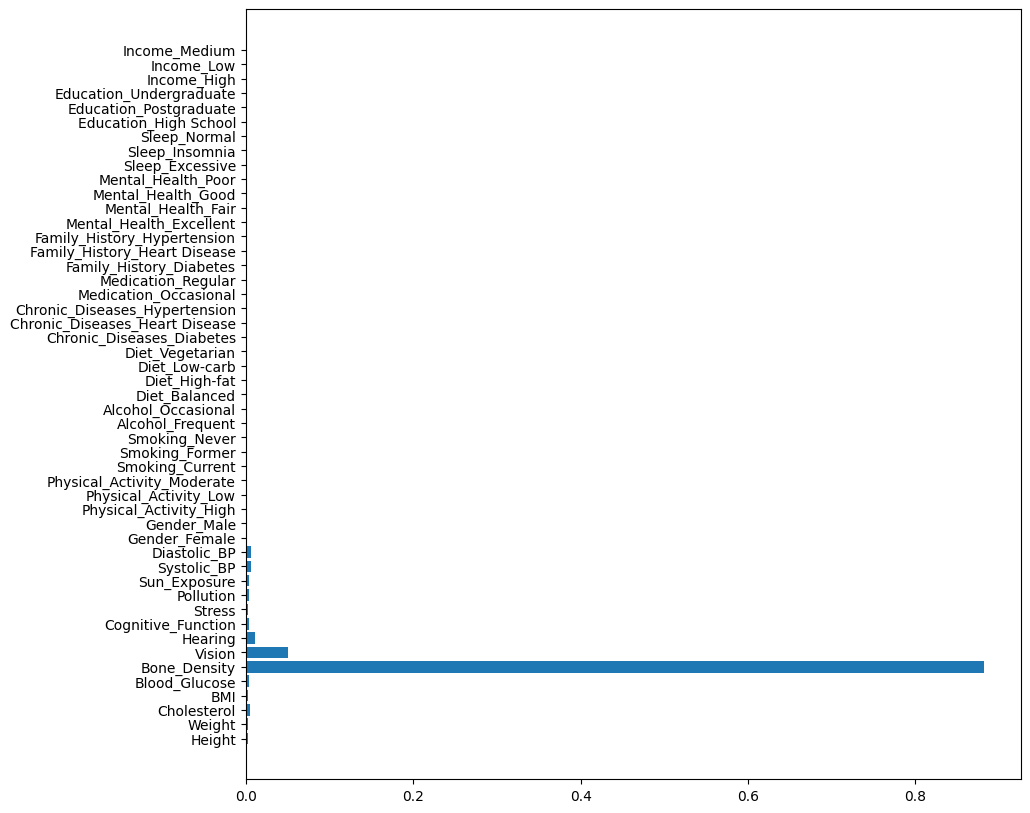

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.barh(X.columns.to_list(), regressor.feature_importances_,)

### Predicted and acutal values comparison

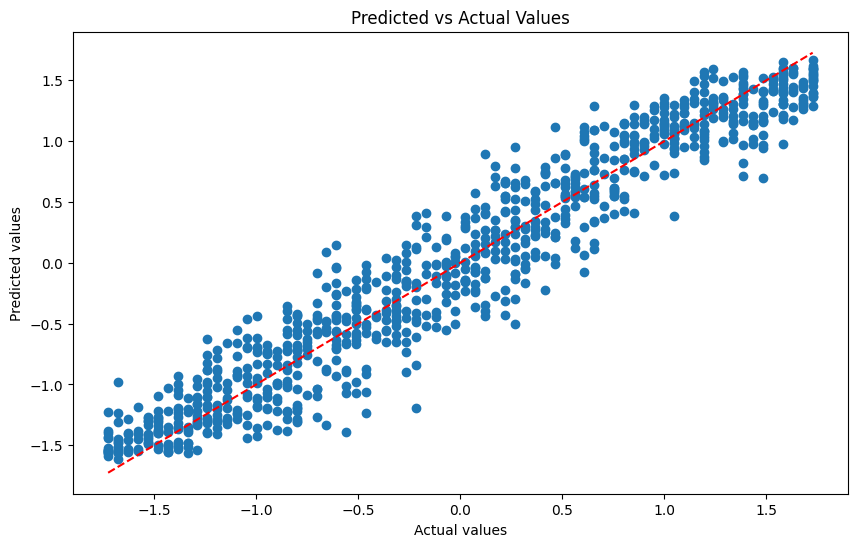

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

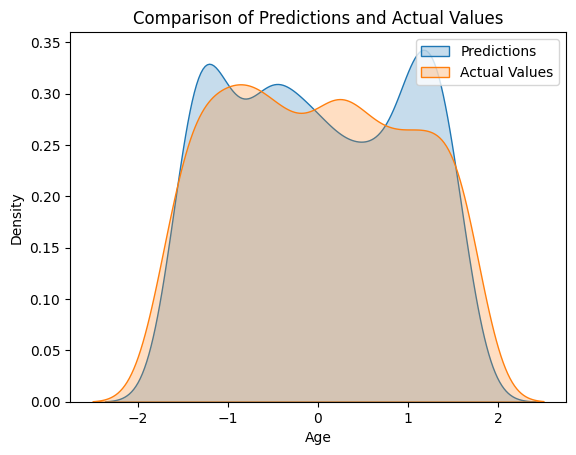

In [29]:
import seaborn as sns
sns.kdeplot(y_pred, label='Predictions', fill=True)
sns.kdeplot(y_test, label='Actual Values', fill=True)
plt.title('Comparison of Predictions and Actual Values')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

## Export trained model

In [10]:
import joblib

model_name = '../models/Random-Forest/random_forest_regression.sav'
joblib.dump(regressor, model_name, compress=3)

['../models/Random-Forest/random_forest_regression.sav']